# An Introduction to FEAST v3.1

FEAST v3.1 is the Decemeber 2020 release of the Fugitive Emmissions Abatement Simulation Toolkit (FEAST). The toolkit simulates emissions from natural gas fields and the efficacy of leak detection and repair programs. This tutorial gives an example of how to generate an example emissions scenario in FEAST 3.1, define LDAR programs and analyze results. The tutorial is interactive, so feel free to experiment with the code cells and discover how your changes affect the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import feast
import pickle
from multiprocessing import Pool

# Defining an emission scenario
FEAST requires all potential emission sources to be declared as Components. Components are characterized by their emission production rate, emission size distribution, and the fraction of components expected to be emitting at the beginning of the simulation. In order to improve transparency, FEAST 3.1 does not have a "default" scenario. All emitters must be defined directly in order to run the simulation.

## Define fugitive components
For this example, we will define exactly one type of component: a fugitive emitter. Additional types of components can be created in the same way. Venting components (that is, components that are intended to produce emissions) can be created by setting the "base_reparable" variable to False. In real production sites vented and fugitive emissions will both be present.

In [2]:
comp_fug = feast.EmissionSimModules.infrastructure_classes.Component(
    name='Fugitive emitters',
    emission_data_path='ExampleData/DataObjectInstances/production_emissions.p',
    emission_per_comp=0.00231,  # Fraction of components expected to be emitting at the beginning of the simulation.
    # emission_production_rate is set to about 5 new emissions per well per year
    emission_production_rate=5.4 / 650 / 365,  # number of new emissions per component per day
    repair_cost_path='ExampleData/DataObjectInstances/fernandez_leak_repair_costs_2006.p',
    base_reparable=True
)

## Define a production Site
A site is made of a collection of components. The components are stored in the variable comp_dict. The analyst may include many component types in the comp_dict.

Using the copy library is good practice if a component type is going to be reused in multiple sites to avoid shared parameters.

In [3]:
wells_per_site = 2
comps_per_well = 650
basic_site = feast.EmissionSimModules.infrastructure_classes.Site(
    name='basic site',
    comp_dict={
        # ------ The number of components is proportional to the number of wells, ind2
        'Fugitive ': {'number': comps_per_well * wells_per_site,
                     'parameters': copy.deepcopy(comp_fug)},
    },
)

## Define a Time object
FEAST requires the simulation time settings to be declared in a time object.

In [4]:
time = feast.EmissionSimModules.simulation_classes.Time(delta_t=1, end_time=365)

## Define a GasField
All of the sites to be simulated must be collected into a dict and then passed to a GasField object. As of FEAST 3.1, a GasField object may also contain meteorological data.

In [5]:
site_dict = {
    'basic site': {
        'number': 100, # The number of basic_site instances to simulate in the gas_field
        'parameters': basic_site
    }
    # If additional site types are needed, they should be added here as separate dict entries
}
gas_field = feast.EmissionSimModules.infrastructure_classes.GasField(
    sites=site_dict,
    time=time,
    met_data_path='ExampleData/TMY-DataExample.csv'
)

# Define LDAR programs
LDAR programs are made of detection methods, repair methods, and the connections between them. The first step in creating LDAR programs is defining detection and repair methods.

## Define a repair method
A repair method takes one input parameter: the delay (days) between when an emission is detected and when it is repaired.

In [6]:
rep3 = feast.DetectionModules.repair.Repair(repair_delay=3)

## Define detection methods
Detection methods accept a variety of variables that depend on the type of detection method to be simulated. In all cases, a detection method requires a set of conditions to be specified where the probability of detection (PoD) is known. Three examples are demonstrated below.

In [7]:
# An OGI-like example where the PoD depends on emission rate only.
def make_ogi(dispatch_obj):
    points = np.array([0.5, 1, 2, 3, 7]) * 0.01157 # g/s
    probs = np.array([0, 0.25, 0.5, 0.75, 1])
    ogi = feast.DetectionModules.comp_survey.CompSurvey(
        time,
        survey_interval=180, # days
        survey_speed=500, # comps/hr
        ophrs={'begin': 8, 'end': 17},
        labor=400, # $/hr
        detection_variables={'flux': 'mean'},
        detection_probability_points=points,  # g/s
        detection_probabilities=probs,
        dispatch_object=copy.deepcopy(dispatch_obj),
        site_queue=[],
    )
    return ogi
ogi = make_ogi(rep3)

In [8]:
# An OGI-like example that does not automatically survey components but can be dispatched
def make_ogi_no_survey(dispatch_obj):
    points = np.array([0.5, 1, 2, 3, 7]) * 0.01157 # g/s
    probs = np.array([0, 0.25, 0.5, 0.75, 1])
    ogi_no_survey = feast.DetectionModules.comp_survey.CompSurvey(
        time,
        survey_interval=None, # days
        survey_speed=500, # comps/hr
        ophrs={'begin': 8, 'end': 17},
        labor=400, # $/hr
        detection_variables={'flux': 'mean'},
        detection_probability_points=points,  # g/s
        detection_probabilities=probs,
        dispatch_object=copy.deepcopy(dispatch_obj),
        site_queue=[],
    )
    return ogi_no_survey
ogi_no_survey = make_ogi_no_survey(rep3)

In [9]:
# A site level survey method
def make_plane_survey(dispatch_obj):
    points = np.array([25, 50, 100, 200, 400]) * 0.01157 # g/s
    probs = np.array([0, 0.25, 0.5, 0.75, 1])
    plane_survey = feast.DetectionModules.site_survey.SiteSurvey(
        time,
        survey_interval=180, # days
        sites_per_day=200,
        site_cost=100, # $/site
        detection_variables={'flux': 'mean'},
        detection_probability_points=points,
        detection_probabilities=probs,
        dispatch_object=copy.deepcopy(dispatch_obj),
        site_queue=[],
        ophrs={'begin': 8, 'end': 17}
    )
    return plane_survey
plane_survey = make_plane_survey(ogi_no_survey)

In [10]:
# Continuous monitor method where detection depends on emission rate and windspeed. 
def make_cont_monitor(dispatch_obj):
    points = [[0.5, 1], 
              [1.0, 1], 
              [1.1, 1], 
              [0.5, 5], 
              [1.0, 5], 
              [1.1, 5],
              [0.5, 5.1], 
              [1.0, 5.1],
              [1.1, 5.1]]
    time_to_detect_days = [np.infty, 1, 0, np.infty, 5, 0, np.infty, np.infty, np.infty]
    cont_monitor = feast.DetectionModules.site_monitor.SiteMonitor(
        time,
        time_to_detect_points=points,
        time_to_detect_days=time_to_detect_days,
        detection_variables={'flux': 'mean', 'wind speed': 'mean'},
        site_queue=list(range(gas_field.n_sites)),
        dispatch_object=copy.deepcopy(dispatch_obj),
        ophrs={'begin': 8, 'end': 17}
    )
    return cont_monitor
cont_monitor = make_cont_monitor(ogi_no_survey)

## Collect detection methods into LDARPrograms

In [11]:
# Define LDAR programs
ogi_survey = feast.DetectionModules.ldar_program.LDARProgram(
    copy.deepcopy(gas_field), {'ogi': copy.deepcopy(ogi)},
)
# tiered survey
tech_dict = {
    'plane': plane_survey,
    'ogi': plane_survey.dispatch_object
}
plane_ogi_survey = feast.DetectionModules.ldar_program.LDARProgram(
    copy.deepcopy(gas_field), tech_dict,
)

# continuous monitor
tech_dict = {
    'cm': cont_monitor,
    'ogi': cont_monitor.dispatch_object
}
cm_ogi = feast.DetectionModules.ldar_program.LDARProgram(
    copy.deepcopy(gas_field), tech_dict,
)

# All programs
ldar_dict = {
    # Note: continuous monitor simulations dominate the computation load.
    # Comment out the next line to exclude the continuous monitor program from the simulation.
    'cm': cm_ogi,
    'ogi': ogi_survey,
    'plane': plane_ogi_survey
}


# Run simulation

In [12]:
scenario = feast.EmissionSimModules.simulation_classes.Scenario(time=time, 
                                                                gas_field=gas_field, 
                                                                ldar_program_dict=ldar_dict)
scenario.run(dir_out='TutorialResults', display_status=True, save_method='pickle')

The evaluation is 0% complete
The evaluation is 10% complete
The evaluation is 20% complete
The evaluation is 30% complete
The evaluation is 40% complete
The evaluation is 50% complete
The evaluation is 60% complete
The evaluation is 70% complete
The evaluation is 80% complete
The evaluation is 90% complete


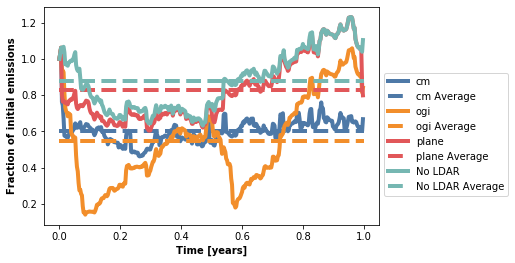

In [13]:
from feast.ResultsProcessing.plotting_functions import time_series
# The next line loads results from the most recently completed simulation.
realn = len(os.listdir('TutorialResults')) - 1
time_series('TutorialResults/realization' + str(realn) + '.p', line_width=4)

# Evaluating many simulations
FEAST is a stochastic model. Therefore, many iterations of the model should be considered to evaluate the variability between iterations. The cells below run 30 iterations of a simulation similar to that defined above, but without a continuous monitor method so that simulations can complete more quickly. The cell will take a few minutes to evaluate.

Note that many objects in FEAST must be re-created during each iteration in order to avoid results from the previous iteration persisting into the next simulation.

In [14]:
from tutorial_helper import make_iteration
from multiprocessing import Pool

In [15]:
nreal=30
with Pool(10) as p:
    p.map(make_iteration, [ind for ind in range(nreal)])

## Analyzing results
FEAST offers a few simple tools for analyzing multiple pickled results files. 
The results_analysis function calculates the net present value of the of finding leaks and repairing leaks. If the gas_price parameter is set greater than zero, it also accounts for the value of avoided emissions. The npv output of the function returns a dict containing one NxK array for each of these cash flows, where N is the number of iterations, and K is the number of technologies. The order of LDAR programs is specified by the *programs* output parameter.

In addition, *em_timeseries* contains an array of emission timeseries with dimension (N_programs + 1, N_timesteps, N_iterations). The first dimension is N_programs+1 because it includes an entry for the Null scenario as well as each LDAR program.

The abatement_cost_plotter function uses the results_analysis function to calculate and plot the mitigation cost of each LDAR program.

In [16]:
ra = feast.ResultsProcessing.results_analysis_functions.results_analysis
npv, em_timeseries, programs = ra('TutorialResults-MC', gas_price=0, discount_rate=0)

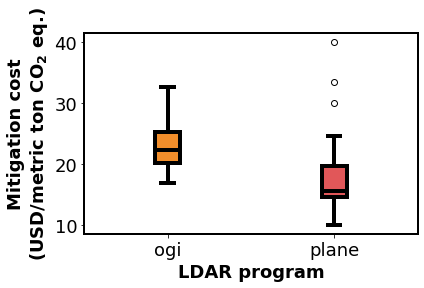

In [17]:
feast.ResultsProcessing.plotting_functions.abatement_cost_plotter('TutorialResults-MC', 
                                                                  gwp=34, discount_rate=0, gas_price=0)

## Utilizing the JSON save method
When running many simulations, the 'pickle' save method results in unnecessarily large results files. The JSON save method provides a more efficient alternative. The resulting files can be loaded without importing FEAST.

In [18]:
time = feast.EmissionSimModules.simulation_classes.Time(delta_t=1, end_time=365)
gas_field = feast.EmissionSimModules.infrastructure_classes.GasField(
    sites=site_dict,
    time=time,
    met_data_path='ExampleData/TMY-DataExample.csv'
)
ogi = make_ogi(rep3)
ogi_no_survey = make_ogi_no_survey(rep3)
plane_survey = make_plane_survey(ogi_no_survey)
# LDAR programs
ogi_survey = feast.DetectionModules.ldar_program.LDARProgram(
    copy.deepcopy(gas_field), {'ogi': ogi},
)
# tiered survey
tech_dict = {
    'plane': plane_survey,
    'ogi': plane_survey.dispatch_object
}
plane_ogi_survey = feast.DetectionModules.ldar_program.LDARProgram(
    copy.deepcopy(gas_field), tech_dict,
)
ldar_dict = {
    'ogi': ogi_survey,
    'plane': plane_ogi_survey
}
scenario = feast.EmissionSimModules.simulation_classes.Scenario(time=time, 
                                                            gas_field=gas_field, 
                                                            ldar_program_dict=ldar_dict)
scenario.run(dir_out='TutorialResults-json', display_status=True, save_method='json')

The evaluation is 0% complete
The evaluation is 10% complete
The evaluation is 20% complete
The evaluation is 30% complete
The evaluation is 40% complete
The evaluation is 50% complete
The evaluation is 60% complete
The evaluation is 70% complete
The evaluation is 80% complete
The evaluation is 90% complete


In [19]:
import json
with open('TutorialResults-json/realization0.json') as f:
    res = json.load(f)

In [20]:
# A json result file is imported as a multilevel dict. The top level of the dict contains one entry for each LDAR program.
res.keys()

dict_keys(['ogi', 'plane', 'Null'])

In [21]:
# The second level of the dict contains emission and vent timeseries, 
# as well as repair costs, and keys to additional levels of the dict
# For complete documentation of the data structure, 
res['plane'].keys()

dict_keys(['emission timeseries', 'vent timeseries', 'repair cost', 'plane', 'ogi', 'ogi repair'])

In [22]:
# To learn more about what is available in each layer, check out the keys!
res['plane']['ogi'].keys()

dict_keys(['deployment costs', 'deployment count', 'op env site fails', 'op env field fails'])